<a href="https://colab.research.google.com/github/Codedestructor56/Bacteria-detection/blob/master/Hate_Speech_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers nlpaug

In [2]:
#importing all the required libraries
import torch
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import transformers
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from joblib import Parallel, delayed
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import string
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#connecting to google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#reading the training data into a dataframe
train_df=pd.read_csv("drive/MyDrive/train.csv")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_df.shape

(159571, 8)

In [6]:
train_df=train_df[:20000]

In [7]:
X=train_df['comment_text']
y=train_df.drop(columns=['comment_text','id'])

In [8]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=15)

In [9]:
augmented_sentences=[]
augmented_sentences_labels=[]
for column in y.columns:
  for i in range(X.index.stop-1):
    if y[column][i]==1:
      temps=aug.augment(X[i],n=5)
      for sent in temps:
        augmented_sentences.append(sent)
        augmented_sentences_labels.append(
            list(y.iloc[i].values)
        )

In [11]:
print(len(augmented_sentences_labels))
print(len(augmented_sentences))

22575
22575


In [12]:
X.shape

(20000,)

In [13]:
X=X.append(pd.Series(augmented_sentences),ignore_index=True)
for row_values in augmented_sentences_labels:
    new_row_series = pd.Series(row_values, index=y.columns)
    y = y.append(new_row_series, ignore_index=True)

In [14]:
X[10905]

'"\n\n Steven E. Jones \n\nin response to  \n\nplease stop deleting tags at will.\n\nThose tags were originally chosen by Morton  devonshire, who made the following change first. \n\nAnyone making such a change should not be editing wikipedia.\n\nYour own comments (""conspiracy theorist"") is harrassment and not professional. Using that term shows that you are not taking the issue seriously. Therefore, you should not be editing these 9/11 pages.\n "'

In [15]:
lemmatizer=WordNetLemmatizer()

In [16]:
def process_text(text):

    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    text = re.sub(r'$\w*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'#', '', text)
    text = str(re.sub("\S*\d\S*", "", text).strip())
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tokens = tokenizer.tokenize(text)

    texts_clean = []
    for word in tokens:
        if (word not in stopwords_english and
                word not in string.punctuation+'...'):
            stem_word = lemmatizer.lemmatize(word,"v")
            texts_clean.append(stem_word)

    return " ".join(texts_clean)

In [17]:
process_text(X[10905])

'steven e jones response please stop delete tag tag originally choose morton devonshire make follow change first anyone make change edit wikipedia comment conspiracy theorist harrassment professional use term show take issue seriously therefore edit page'

In [18]:
X=X.apply(lambda x:process_text(str(x)))

In [20]:
X_train, X_val, y_train, y_val=train_test_split(X,y,test_size=0.2, random_state=42)

In [23]:
X_train, X_val, y_train, y_val=X_train[:10000], X_val[:10000], y_train[:10000], y_val[:10000]

We need to use BERT transformer to generate word embeddings:

In [24]:
#loading bert model and tokenizer
model_name="bert-base-uncased"
tokenizer=transformers.BertTokenizer.from_pretrained(model_name)
bert_model=transformers.BertModel.from_pretrained(model_name)

In [25]:
def conv_to_tensor(text,max_len):
  tokenized_arr=tokenizer.encode(text,add_special_tokens=True)[:max_len]
  padded_arr=np.array(tokenized_arr+[0]*(max_len-len(tokenized_arr)))
  return padded_arr

In [26]:
conv_to_tensor(X_train.iloc[0],100)

array([  101,  4323,  2299,  3422, 13229,  2086,  2428,  2215,  2113,
        2171,  2783, 27660,  2614,  4323,  2299,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
embeddings=[]
embeddings.append(Parallel(n_jobs=-1)(delayed(conv_to_tensor)(text,100) for text in X_train))

In [29]:
embeddings=torch.squeeze(torch.tensor(embeddings,dtype=torch.float32)).long().to(device)

In [30]:
embeddings.shape

torch.Size([8000, 100])

In [31]:
print(embeddings)

tensor([[  101,  4323,  2299,  ...,     0,     0,     0],
        [  101,  1027,  1024,  ..., 16390,  5587,  2592],
        [  101,  4797,  2310,  ...,     0,     0,     0],
        ...,
        [  101,  4299,  2178,  ...,     0,     0,     0],
        [  101,  6090, 24979,  ...,     0,     0,     0],
        [  101,  3120, 21893,  ...,     0,     0,     0]], device='cuda:0')


In [32]:
val_embeddings=[]
val_embeddings.append(Parallel(n_jobs=-1)(delayed(conv_to_tensor)(text,100) for text in X_val))

In [33]:
val_embeddings=torch.squeeze(torch.tensor(val_embeddings,dtype=torch.float32)).long().to(device)

In [34]:
train_data_loader=DataLoader(embeddings,batch_size=128,shuffle=True)
val_data_loader=DataLoader(val_embeddings,batch_size=128,shuffle=False)

In [35]:
bert_model.to(device)

with torch.no_grad():
    train_data = iter(train_data_loader)
    val_data = iter(val_data_loader)

    x_train = torch.empty(0).to(device)
    x_val = torch.empty(0).to(device)

    for i in range(len(train_data_loader)):
        batch = next(train_data)
        outputs = bert_model(batch.to(device))
        x_train = torch.cat((x_train, outputs[0]), dim=0)
        print(f"Iteration: {i} for train")

    for i in range(len(val_data_loader)):
        batch1 = next(val_data)
        outputs1 = bert_model(batch1.to(device))
        x_val = torch.cat((x_val, outputs1[0]), dim=0)
        print(f"Iteration: {i} for val")


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Iteration: 0 for train
Iteration: 1 for train
Iteration: 2 for train
Iteration: 3 for train
Iteration: 4 for train
Iteration: 5 for train
Iteration: 6 for train
Iteration: 7 for train
Iteration: 8 for train
Iteration: 9 for train
Iteration: 10 for train
Iteration: 11 for train
Iteration: 12 for train
Iteration: 13 for train
Iteration: 14 for train
Iteration: 15 for train
Iteration: 16 for train
Iteration: 17 for train
Iteration: 18 for train
Iteration: 19 for train
Iteration: 20 for train
Iteration: 21 for train
Iteration: 22 for train
Iteration: 23 for train
Iteration: 24 for train
Iteration: 25 for train
Iteration: 26 for train
Iteration: 27 for train
Iteration: 28 for train
Iteration: 29 for train
Iteration: 30 for train
Iteration: 31 for train
Iteration: 32 for train
Iteration: 33 for train
Iteration: 34 for train
Iteration: 35 for train
Iteration: 36 for train
Iteration: 37 for train
Iteration: 38 for train
Iteration: 39 for train
Iteration: 40 for train
Iteration: 41 for train
It

In [36]:
torch.cuda.empty_cache()

In [37]:
x_train.shape

torch.Size([8000, 100, 768])

In [38]:
class CustomDataset(Dataset):
  def __init__(self,embeddings,labels):
    self.embeddings=embeddings
    self.labels=torch.tensor(np.array(labels),dtype=torch.float32).to(device)
  def __len__(self):
    return self.embeddings.shape[0]
  def __getitem__(self,idx):
    return {"embedding":self.embeddings[idx],"label":self.labels[idx]}

In [39]:
train_data=CustomDataset(x_train,y_train)
val_data=CustomDataset(x_val,y_val)

In [40]:
train_data_loader=DataLoader(train_data,batch_size=10,shuffle=True)
val_data_loader=DataLoader(val_data,batch_size=10,shuffle=False)

In [41]:
batch=iter(train_data_loader)
next(batch)['embedding'].shape

torch.Size([10, 100, 768])

In [42]:
class ClassCNN(torch.nn.Module):
  def __init__(self,embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
    super(ClassCNN, self).__init__()
    self.static = static
    self.embed = nn.Embedding(embed_num, embed_dim)
    self.convs1 = nn.ModuleList([nn.Conv2d(1, kernel_num, (K, embed_dim)) for K in kernel_sizes])
    self.dropout = nn.Dropout(dropout)
    self.fc1 = nn.Linear(len(kernel_sizes) * kernel_num, class_num)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    if self.static:
        x = torch.autograd.Variable(x)

    x = x.unsqueeze(1)
    x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]

    x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]

    x = torch.cat(x, 1)
    x = self.dropout(x)
    logit = self.fc1(x)
    output = self.sigmoid(logit)
    return output

In [43]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [44]:
model = ClassCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
).to(device)

In [45]:
#sample:
model(next(batch)['embedding']).shape

torch.Size([10, 6])

In [46]:
criterion = torch.nn.BCELoss()
optimizer = transformers.AdamW(model.parameters(), lr=0.002)

In [47]:
from tqdm import tqdm

model.to(device)
model.train()

num_epochs = 30
best_validation_loss = float('inf')
save_interval = 5
train_losses=[]
val_losses=[]

for epoch in range(num_epochs):
    total_loss = 0.0

    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(batch['embedding'])
        optimizer.zero_grad()

        loss = criterion(outputs, batch['label'])

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_data_loader)
    train_losses.append(average_loss)

    model.eval()
    with torch.no_grad():
      val_loss=0
      for batch in val_data_loader:
        batch={k: v.to(device) for k, v in batch.items()}

        outputs=model(batch['embedding'])
        val_loss=criterion(outputs,batch['label'])
        val_loss+=val_loss.item()

      val_loss /= len(val_data_loader)
      val_losses.append(val_loss.cpu())
      if epoch % save_interval == 0:
          best_validation_loss = val_loss
          best_model_state = model.state_dict()
          model_dict = {
                'model_state_dict': best_model_state,
                'model_architecture': model.state_dict()
            }
          print("Saving model....")
          torch.save(best_model_state, f"best_model_epoch_{epoch}.pt")

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {average_loss:.4f} - Validation Loss: {val_loss:.4f}")
print("Training finished.")


Epoch 1/30: 100%|██████████| 800/800 [00:06<00:00, 115.57it/s]


Saving model....
Epoch 1/30 - Train Loss: 0.2505 - Validation Loss: 0.0014


Epoch 2/30: 100%|██████████| 800/800 [00:05<00:00, 153.15it/s]


Epoch 2/30 - Train Loss: 0.1460 - Validation Loss: 0.0013


Epoch 3/30: 100%|██████████| 800/800 [00:05<00:00, 149.46it/s]


Epoch 3/30 - Train Loss: 0.1430 - Validation Loss: 0.0014


Epoch 4/30: 100%|██████████| 800/800 [00:05<00:00, 159.25it/s]


Epoch 4/30 - Train Loss: 0.1409 - Validation Loss: 0.0015


Epoch 5/30: 100%|██████████| 800/800 [00:05<00:00, 157.76it/s]


Epoch 5/30 - Train Loss: 0.1369 - Validation Loss: 0.0015


Epoch 6/30: 100%|██████████| 800/800 [00:04<00:00, 162.03it/s]


Saving model....
Epoch 6/30 - Train Loss: 0.1329 - Validation Loss: 0.0014


Epoch 7/30: 100%|██████████| 800/800 [00:04<00:00, 162.71it/s]


Epoch 7/30 - Train Loss: 0.1290 - Validation Loss: 0.0017


Epoch 8/30: 100%|██████████| 800/800 [00:05<00:00, 157.31it/s]


Epoch 8/30 - Train Loss: 0.1227 - Validation Loss: 0.0016


Epoch 9/30: 100%|██████████| 800/800 [00:04<00:00, 162.72it/s]


Epoch 9/30 - Train Loss: 0.1186 - Validation Loss: 0.0018


Epoch 10/30: 100%|██████████| 800/800 [00:05<00:00, 158.66it/s]


Epoch 10/30 - Train Loss: 0.1119 - Validation Loss: 0.0017


Epoch 11/30: 100%|██████████| 800/800 [00:05<00:00, 159.47it/s]


Saving model....
Epoch 11/30 - Train Loss: 0.1087 - Validation Loss: 0.0017


Epoch 12/30: 100%|██████████| 800/800 [00:04<00:00, 162.55it/s]


Epoch 12/30 - Train Loss: 0.1038 - Validation Loss: 0.0017


Epoch 13/30: 100%|██████████| 800/800 [00:05<00:00, 157.21it/s]


Epoch 13/30 - Train Loss: 0.1000 - Validation Loss: 0.0017


Epoch 14/30: 100%|██████████| 800/800 [00:04<00:00, 162.46it/s]


Epoch 14/30 - Train Loss: 0.0952 - Validation Loss: 0.0020


Epoch 15/30: 100%|██████████| 800/800 [00:04<00:00, 161.74it/s]


Epoch 15/30 - Train Loss: 0.0925 - Validation Loss: 0.0019


Epoch 16/30: 100%|██████████| 800/800 [00:05<00:00, 157.24it/s]


Saving model....
Epoch 16/30 - Train Loss: 0.0884 - Validation Loss: 0.0018


Epoch 17/30: 100%|██████████| 800/800 [00:04<00:00, 162.10it/s]


Epoch 17/30 - Train Loss: 0.0850 - Validation Loss: 0.0018


Epoch 18/30: 100%|██████████| 800/800 [00:05<00:00, 158.67it/s]


Epoch 18/30 - Train Loss: 0.0805 - Validation Loss: 0.0020


Epoch 19/30: 100%|██████████| 800/800 [00:04<00:00, 160.87it/s]


Epoch 19/30 - Train Loss: 0.0787 - Validation Loss: 0.0021


Epoch 20/30: 100%|██████████| 800/800 [00:04<00:00, 162.33it/s]


Epoch 20/30 - Train Loss: 0.0766 - Validation Loss: 0.0023


Epoch 21/30: 100%|██████████| 800/800 [00:05<00:00, 157.29it/s]


Saving model....
Epoch 21/30 - Train Loss: 0.0738 - Validation Loss: 0.0020


Epoch 22/30: 100%|██████████| 800/800 [00:04<00:00, 162.72it/s]


Epoch 22/30 - Train Loss: 0.0700 - Validation Loss: 0.0022


Epoch 23/30: 100%|██████████| 800/800 [00:04<00:00, 160.21it/s]


Epoch 23/30 - Train Loss: 0.0667 - Validation Loss: 0.0020


Epoch 24/30: 100%|██████████| 800/800 [00:05<00:00, 159.42it/s]


Epoch 24/30 - Train Loss: 0.0662 - Validation Loss: 0.0018


Epoch 25/30: 100%|██████████| 800/800 [00:04<00:00, 162.29it/s]


Epoch 25/30 - Train Loss: 0.0664 - Validation Loss: 0.0022


Epoch 26/30: 100%|██████████| 800/800 [00:05<00:00, 156.64it/s]


Saving model....
Epoch 26/30 - Train Loss: 0.0613 - Validation Loss: 0.0022


Epoch 27/30: 100%|██████████| 800/800 [00:04<00:00, 162.33it/s]


Epoch 27/30 - Train Loss: 0.0623 - Validation Loss: 0.0024


Epoch 28/30: 100%|██████████| 800/800 [00:04<00:00, 161.79it/s]


Epoch 28/30 - Train Loss: 0.0595 - Validation Loss: 0.0029


Epoch 29/30: 100%|██████████| 800/800 [00:05<00:00, 157.70it/s]


Epoch 29/30 - Train Loss: 0.0577 - Validation Loss: 0.0027


Epoch 30/30: 100%|██████████| 800/800 [00:04<00:00, 163.45it/s]


Epoch 30/30 - Train Loss: 0.0581 - Validation Loss: 0.0024
Training finished.


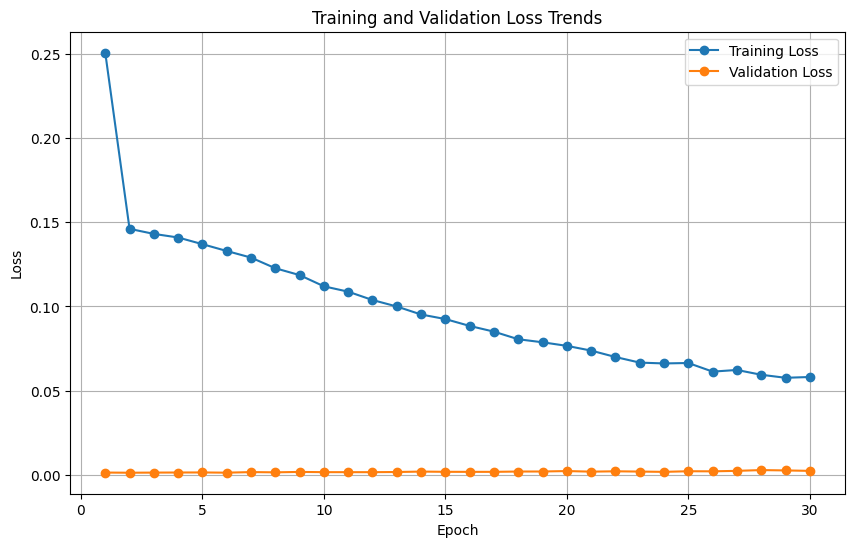

In [48]:
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Trends")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
y.sum().sum()/y.count().sum()

0.036833333333333336

so, the data is imbalanced, we will calculate the auc score.

In [50]:
model.eval()
with torch.no_grad():
  y_preds=[]
  for batch in val_data_loader:
    batch={k: v.to(device) for k, v in batch.items()}
    pred_labels=model(batch['embedding'])
    y_preds.extend(pred_labels.cpu().numpy().tolist())

In [51]:
y_preds=np.array(y_preds)
y_preds.shape

(2000, 6)

In [52]:
from sklearn.metrics import roc_auc_score
auc=roc_auc_score(y_val.values,y_preds,average=None)
df_accuracy = pd.DataFrame({"label": y.columns, "auc": auc})
df_accuracy.sort_values('auc')[::-1]

,label,auc
3,threat,0.724311
1,severe_toxic,0.622307
2,obscene,0.604389
5,identity_hate,0.588416
4,insult,0.559160
0,toxic,0.532088


In [53]:
def get_hate_score(sentence,model):
  sentence=process_text(sentence)
  padded_sent=torch.tensor(conv_to_tensor(sentence,100)).unsqueeze(dim=0).to(device)
  with torch.no_grad():
        embedding = bert_model(padded_sent)
  last_hidden_state = embedding.last_hidden_state
  df_conf=pd.DataFrame({"label": y.columns, "confidence scores": model(last_hidden_state).cpu().detach().numpy()[0]})
  return df_conf


In [62]:
model.load_state_dict(torch.load('best_model_epoch_25.pt',map_location=device))
model.eval()
get_hate_score("some people deny the holocaust",model) #just a sample sentence, you can assign thresholds

,label,confidence scores
0,toxic,0.273797
1,severe_toxic,0.001364
2,obscene,0.081505
3,threat,0.006201
4,insult,0.072336
5,identity_hate,0.005429
